       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        -114.31     34.19                15.0       5612.0          1283.0   
1        -114.47     34.40                19.0       7650.0          1901.0   
2        -114.56     33.69                17.0        720.0           174.0   
3        -114.57     33.64                14.0       1501.0           337.0   
4        -114.57     33.57                20.0       1454.0           326.0   
...          ...       ...                 ...          ...             ...   
16995    -124.26     40.58                52.0       2217.0           394.0   
16996    -124.27     40.69                36.0       2349.0           528.0   
16997    -124.30     41.84                17.0       2677.0           531.0   
16998    -124.30     41.80                19.0       2672.0           552.0   
16999    -124.35     40.54                52.0       1820.0           300.0   

       population  households  median_income  media

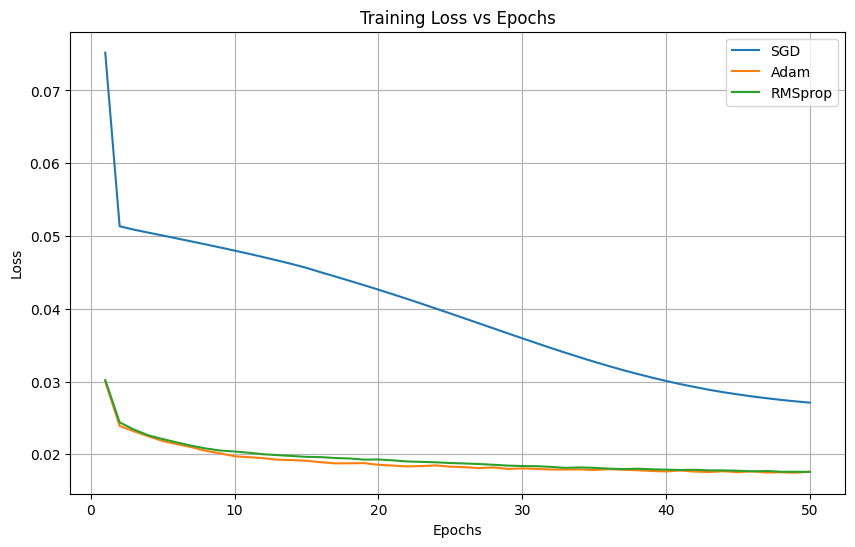

'if optimizer=="SGD":\n    optimizer=optim.SGD(model.parameters(),lr)\nelif optimizer=="Adam":\n    optimizer=optim.Adam(model.parameters(),lr)\nelse:\n    optimizer==optim.RMSProp(model.parameters(),lr)\n\n\n\nprint("Training started")\n\nfor epoch in range(epochs):\n    model.train()\n    train_loss=0.0\n    for inp,out in train_loader:\n        optimizer.zero_grad()\n        output=model(inp)\n        loss_val=lossfunc(output,out)\n        loss_val.backward()\n        optimizer.step()\n        train_loss+=loss_val.item()\n\n    model.eval()\n    val_loss=0.0\n    with torch.no_grad():\n        for inp,out in val_loader:\n            output=model(inp)\n            val_loss+=lossfunc(output,out).item()\n    print(f"Epoch{epoch+1},Train Loss:{train_loss:.4f},Val Loss:{val_loss:.4f}")'

In [15]:
#comparing SGD,Adam,RMSProp on basic MLP model

#loading the base model first
#house price detection basic model
import torch
import pandas as pd
import numpy
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


df_train=pd.read_csv("/content/sample_data/california_housing_train.csv")
print(df_train)
features=["housing_median_age","total_rooms","total_bedrooms","population","households","median_income"]
inp_dim=len(features)
print(inp_dim)

out_dim=1
num_layers=4
batch_size=16

x_train=df_train[features].values
#scaling the values
scaler=MinMaxScaler()
x_train=scaler.fit_transform(x_train)
x_train=torch.from_numpy(x_train).float()
y_train=df_train["median_house_value"].values
y_train=y_train.reshape(-1,1)
y_train=scaler.fit_transform(y_train)
y_train=torch.from_numpy(y_train).float()
print(x_train.shape)
print(y_train)
print(y_train.shape)

#test data
df_test=pd.read_csv("/content/sample_data/california_housing_test.csv")
print(df_test.head)
x_test=df_test[features].values
x_test=scaler.fit_transform(x_test)
x_test=torch.from_numpy(x_test).float()
y_test=df_test["median_house_value"].values
y_test=y_test.reshape(-1,1)
y_test=scaler.fit_transform(y_test)
y_test=torch.from_numpy(y_test).float()
print(x_test.shape)
print(y_test.shape)

train_unsplit_data=torch.utils.data.TensorDataset(x_train,y_train)
ratio=0.8
split_index=int(len(x_train)*ratio)
x_train,x_val=x_train[:split_index],x_train[split_index:]
y_train,y_val=y_train[:split_index],y_train[split_index:]
train_dataset=torch.utils.data.TensorDataset(x_train,y_train)
val_dataset=torch.utils.data.TensorDataset(x_val,y_val)
val_loader=torch.utils.data.DataLoader(val_dataset,batch_size,shuffle=True)
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size,shuffle=True)
test_dataset=torch.utils.data.TensorDataset(x_test,y_test)
test_loader=torch.utils.data.DataLoader(test_dataset,batch_size,shuffle=True)

#training loop
#making the regression model now
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device="cuda" if torch.cuda.is_available() else "cpu"
print(device)
class Housing(nn.Module):
    def __init__(self,inp_dim,out_dim,num_layers,batch_size):
        super(Housing,self).__init__()
        self.inp_dim=inp_dim
        self.out_dim=out_dim
        self.num_layers=out_dim
        self.batch_size=batch_size
        self.layer1=nn.Linear(inp_dim,32)#32 neurons in the 1st hidden layer
        self.layer2=nn.Linear(32,16)#16 neurons in the 2nd hidden layer
        self.layer3=nn.Linear(16,1)
    def forward(self,x):
        x=F.relu(self.layer1(x))
        x=F.relu(self.layer2(x))
        output=self.layer3(x)
        return output

epochs=50
lr=0.001
lossfunc=nn.MSELoss()
model=Housing(inp_dim,out_dim,num_layers,batch_size)
loss_list_epoch=[]

optim_list = ["SGD", "Adam", "RMSprop"]
results = {}

for opt_name in optim_list:
    print(f"\nTraining with optimizer: {opt_name}")

    model = Housing(inp_dim, out_dim, num_layers, batch_size).to(device)
    if opt_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr)
    elif opt_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr)
    elif opt_name == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr)

    train_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inp, out in train_loader:
            inp, out = inp.to(device), out.to(device)
            optimizer.zero_grad()
            output = model(inp)
            loss = lossfunc(output, out)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inp, out in val_loader:
                inp, out = inp.to(device), out.to(device)
                output = model(inp)
                val_loss += lossfunc(output, out).item()
        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

    results[opt_name] = train_losses

plt.figure(figsize=(10, 6))
for opt_name, losses in results.items():
    plt.plot(range(1, epochs + 1), losses, label=opt_name)

plt.title("Training Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


'''if optimizer=="SGD":
    optimizer=optim.SGD(model.parameters(),lr)
elif optimizer=="Adam":
    optimizer=optim.Adam(model.parameters(),lr)
else:
    optimizer==optim.RMSProp(model.parameters(),lr)



print("Training started")

for epoch in range(epochs):
    model.train()
    train_loss=0.0
    for inp,out in train_loader:
        optimizer.zero_grad()
        output=model(inp)
        loss_val=lossfunc(output,out)
        loss_val.backward()
        optimizer.step()
        train_loss+=loss_val.item()

    model.eval()
    val_loss=0.0
    with torch.no_grad():
        for inp,out in val_loader:
            output=model(inp)
            val_loss+=lossfunc(output,out).item()
    print(f"Epoch{epoch+1},Train Loss:{train_loss:.4f},Val Loss:{val_loss:.4f}")'''

